In [16]:
# Importing the necessary libraries
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import MultiColumnLabelEncoder
import xgboost  as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # type: ignore

## Visualization and Data Collection

In [17]:
dataset = pd.read_csv("garments_worker_productivity.csv")
dataset.head

<bound method NDFrame.head of            date   quarter  department        day  team  targeted_productivity  \
0      1/1/2015  Quarter1      sweing   Thursday     8                   0.80   
1      1/1/2015  Quarter1  finishing    Thursday     1                   0.75   
2      1/1/2015  Quarter1      sweing   Thursday    11                   0.80   
3      1/1/2015  Quarter1      sweing   Thursday    12                   0.80   
4      1/1/2015  Quarter1      sweing   Thursday     6                   0.80   
...         ...       ...         ...        ...   ...                    ...   
1192  3/11/2015  Quarter2   finishing  Wednesday    10                   0.75   
1193  3/11/2015  Quarter2   finishing  Wednesday     8                   0.70   
1194  3/11/2015  Quarter2   finishing  Wednesday     7                   0.65   
1195  3/11/2015  Quarter2   finishing  Wednesday     9                   0.75   
1196  3/11/2015  Quarter2   finishing  Wednesday     6                   0.70  

### Correlation analysis

In [18]:
dataset.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


## Data Preprocessing

### Checking the Null Value

In [19]:
print("Data Shape is:",dataset.shape)
dataset.info()

Data Shape is: (1197, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 no

In [20]:
dataset.drop(['wip'],axis =1,inplace= True)

### Handling Categorical Values

In [21]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['month'] = dataset['date'].dt.month
dataset.drop(['date'], axis = 1, inplace= True)

In [22]:
dataset["department"].value_counts()

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

In [23]:
dataset["department"] = dataset["department"].apply(lambda x: "finishing" if x.replace(" ","") == "finishing" else "sweing" )
dataset["department"].value_counts()

department
sweing       691
finishing    506
Name: count, dtype: int64

In [24]:
dataset["month"].value_counts()

month
1    542
2    443
3    212
Name: count, dtype: int64

In [25]:
dataset.describe()

,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091,1.724311
std,3.463963,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488,0.744558
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,1.000000
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,1.000000
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,2.000000
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,2.000000
max,12.000000,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437,3.000000


In [26]:
dataset.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
169,Quarter2,finishing,Saturday,5,0.5,4.15,1440,0,0.0,0,0,8.0,0.337973,1
539,Quarter5,sweing,Saturday,6,0.6,18.79,3960,23,0.0,0,0,33.0,0.600711,1
24,Quarter1,sweing,Saturday,1,0.8,28.08,6300,50,0.0,0,0,56.5,0.800725,1
1037,Quarter1,sweing,Tuesday,5,0.7,27.48,6840,30,0.0,0,0,57.0,0.700660,3
925,Quarter4,finishing,Wednesday,12,0.8,4.60,1800,0,0.0,0,0,15.0,0.899556,2


In [27]:
unique_values = dataset.nunique()
print(unique_values)

quarter                    5
department                 2
day                        6
team                      12
targeted_productivity      9
smv                       70
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
month                      3
dtype: int64


In [28]:
dataset["department"]=dataset["department"].str.strip().str.lower()
dataset["quarter"] =dataset["quarter"].str.strip().str.lower()
dataset["day"]=dataset["day"].str.strip().str.lower()


In [29]:
dataset.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
1109,quarter2,finishing,sunday,1,0.75,3.94,960,0,0.0,0,0,8.0,0.890604,3
287,quarter3,sweing,saturday,1,0.80,48.68,10620,63,0.0,0,0,59.0,0.800117,1
26,quarter1,sweing,saturday,8,0.80,26.16,7080,50,0.0,0,0,59.0,0.800319,1
184,quarter2,sweing,sunday,3,0.80,19.87,6420,0,0.0,0,0,55.0,0.690183,1
619,quarter1,sweing,thursday,1,0.80,22.52,6900,113,0.0,0,0,57.5,1.000019,2


In [32]:
encoder = MultiColumnLabelEncoder.MultiColumnLabelEncoder(columns=['quarter','department','team','day','no_of_style_change','month'])
data_ev = encoder.fit_transform(dataset)
data_ev.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
213,1,0,0,2,0.8,4.15,1440,0,0.0,0,0,8.0,0.640578,0
1088,0,1,1,3,0.8,15.26,4080,75,0.0,0,0,34.0,0.850521,2
48,0,1,2,6,0.8,28.08,4260,50,0.0,0,0,55.5,0.800598,0
727,1,0,5,11,0.8,3.94,960,0,0.0,0,0,8.0,0.541750,1
61,0,0,0,0,0.8,3.94,1920,0,0.0,0,0,8.0,0.961059,0


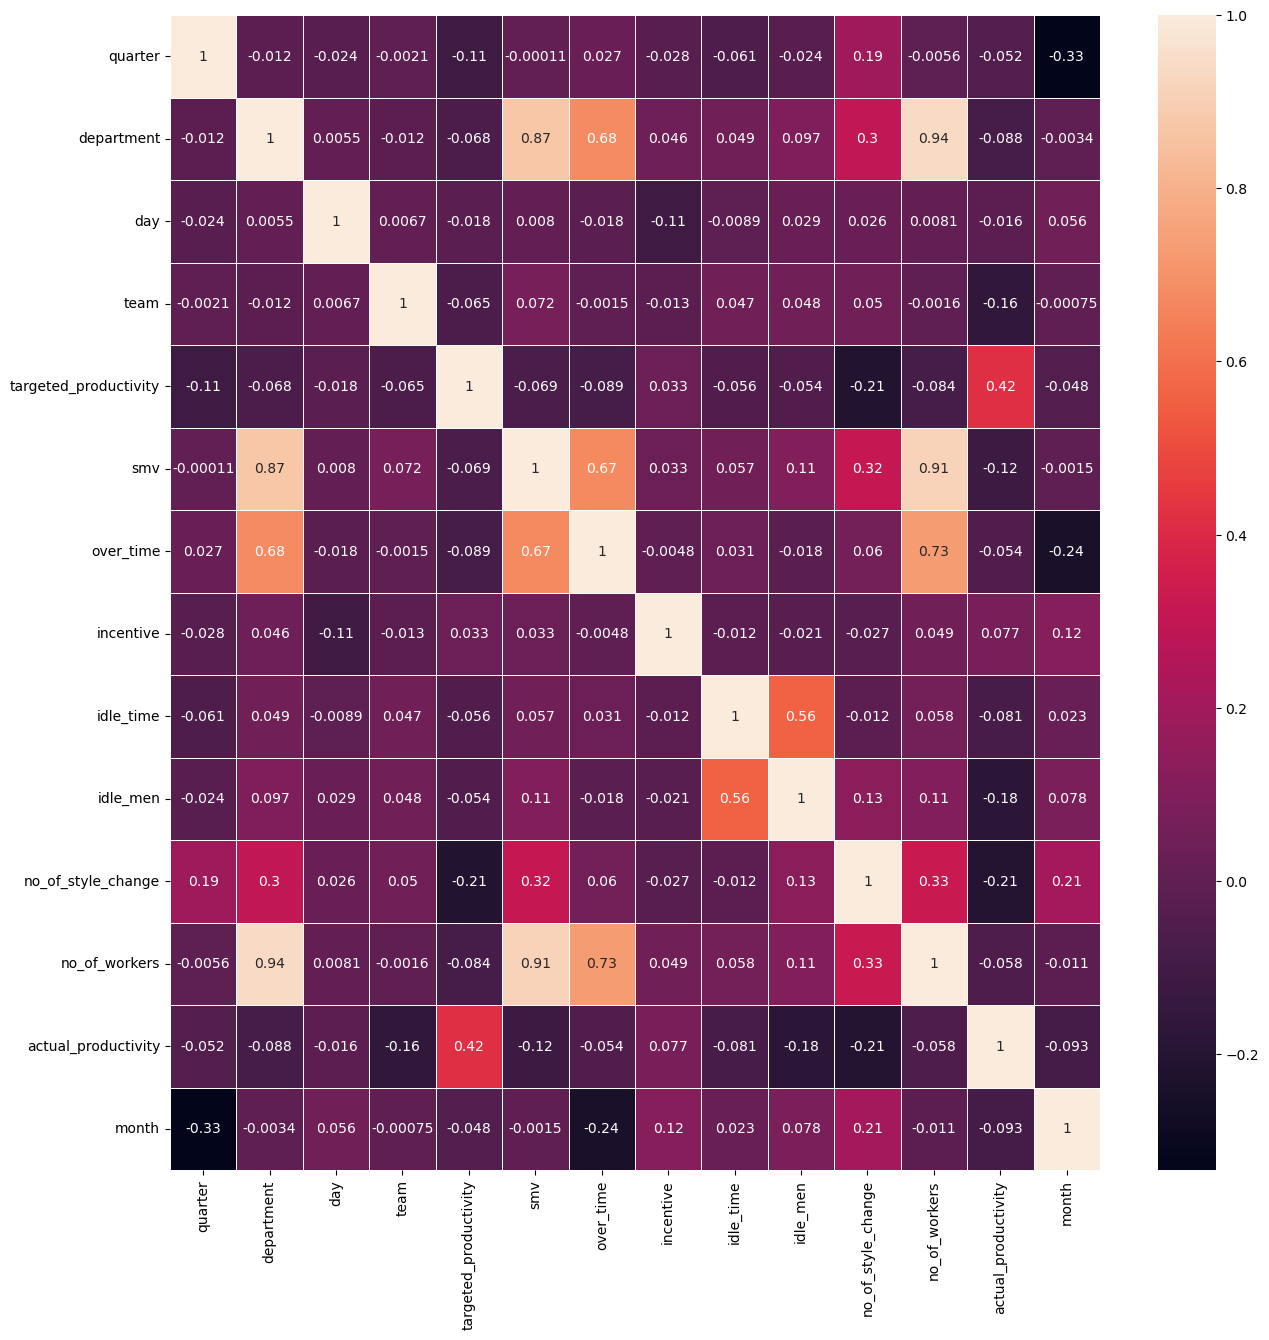

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected function name: use plt.subplots() instead of plt.subplot()
corrMatrix = data_ev.corr()
fig, ax = plt.subplots(figsize=(15, 15))  

# Ensure corrMatrix is defined before using it
sns.heatmap(corrMatrix, annot=True, linewidths=0.5, ax=ax)

plt.show()


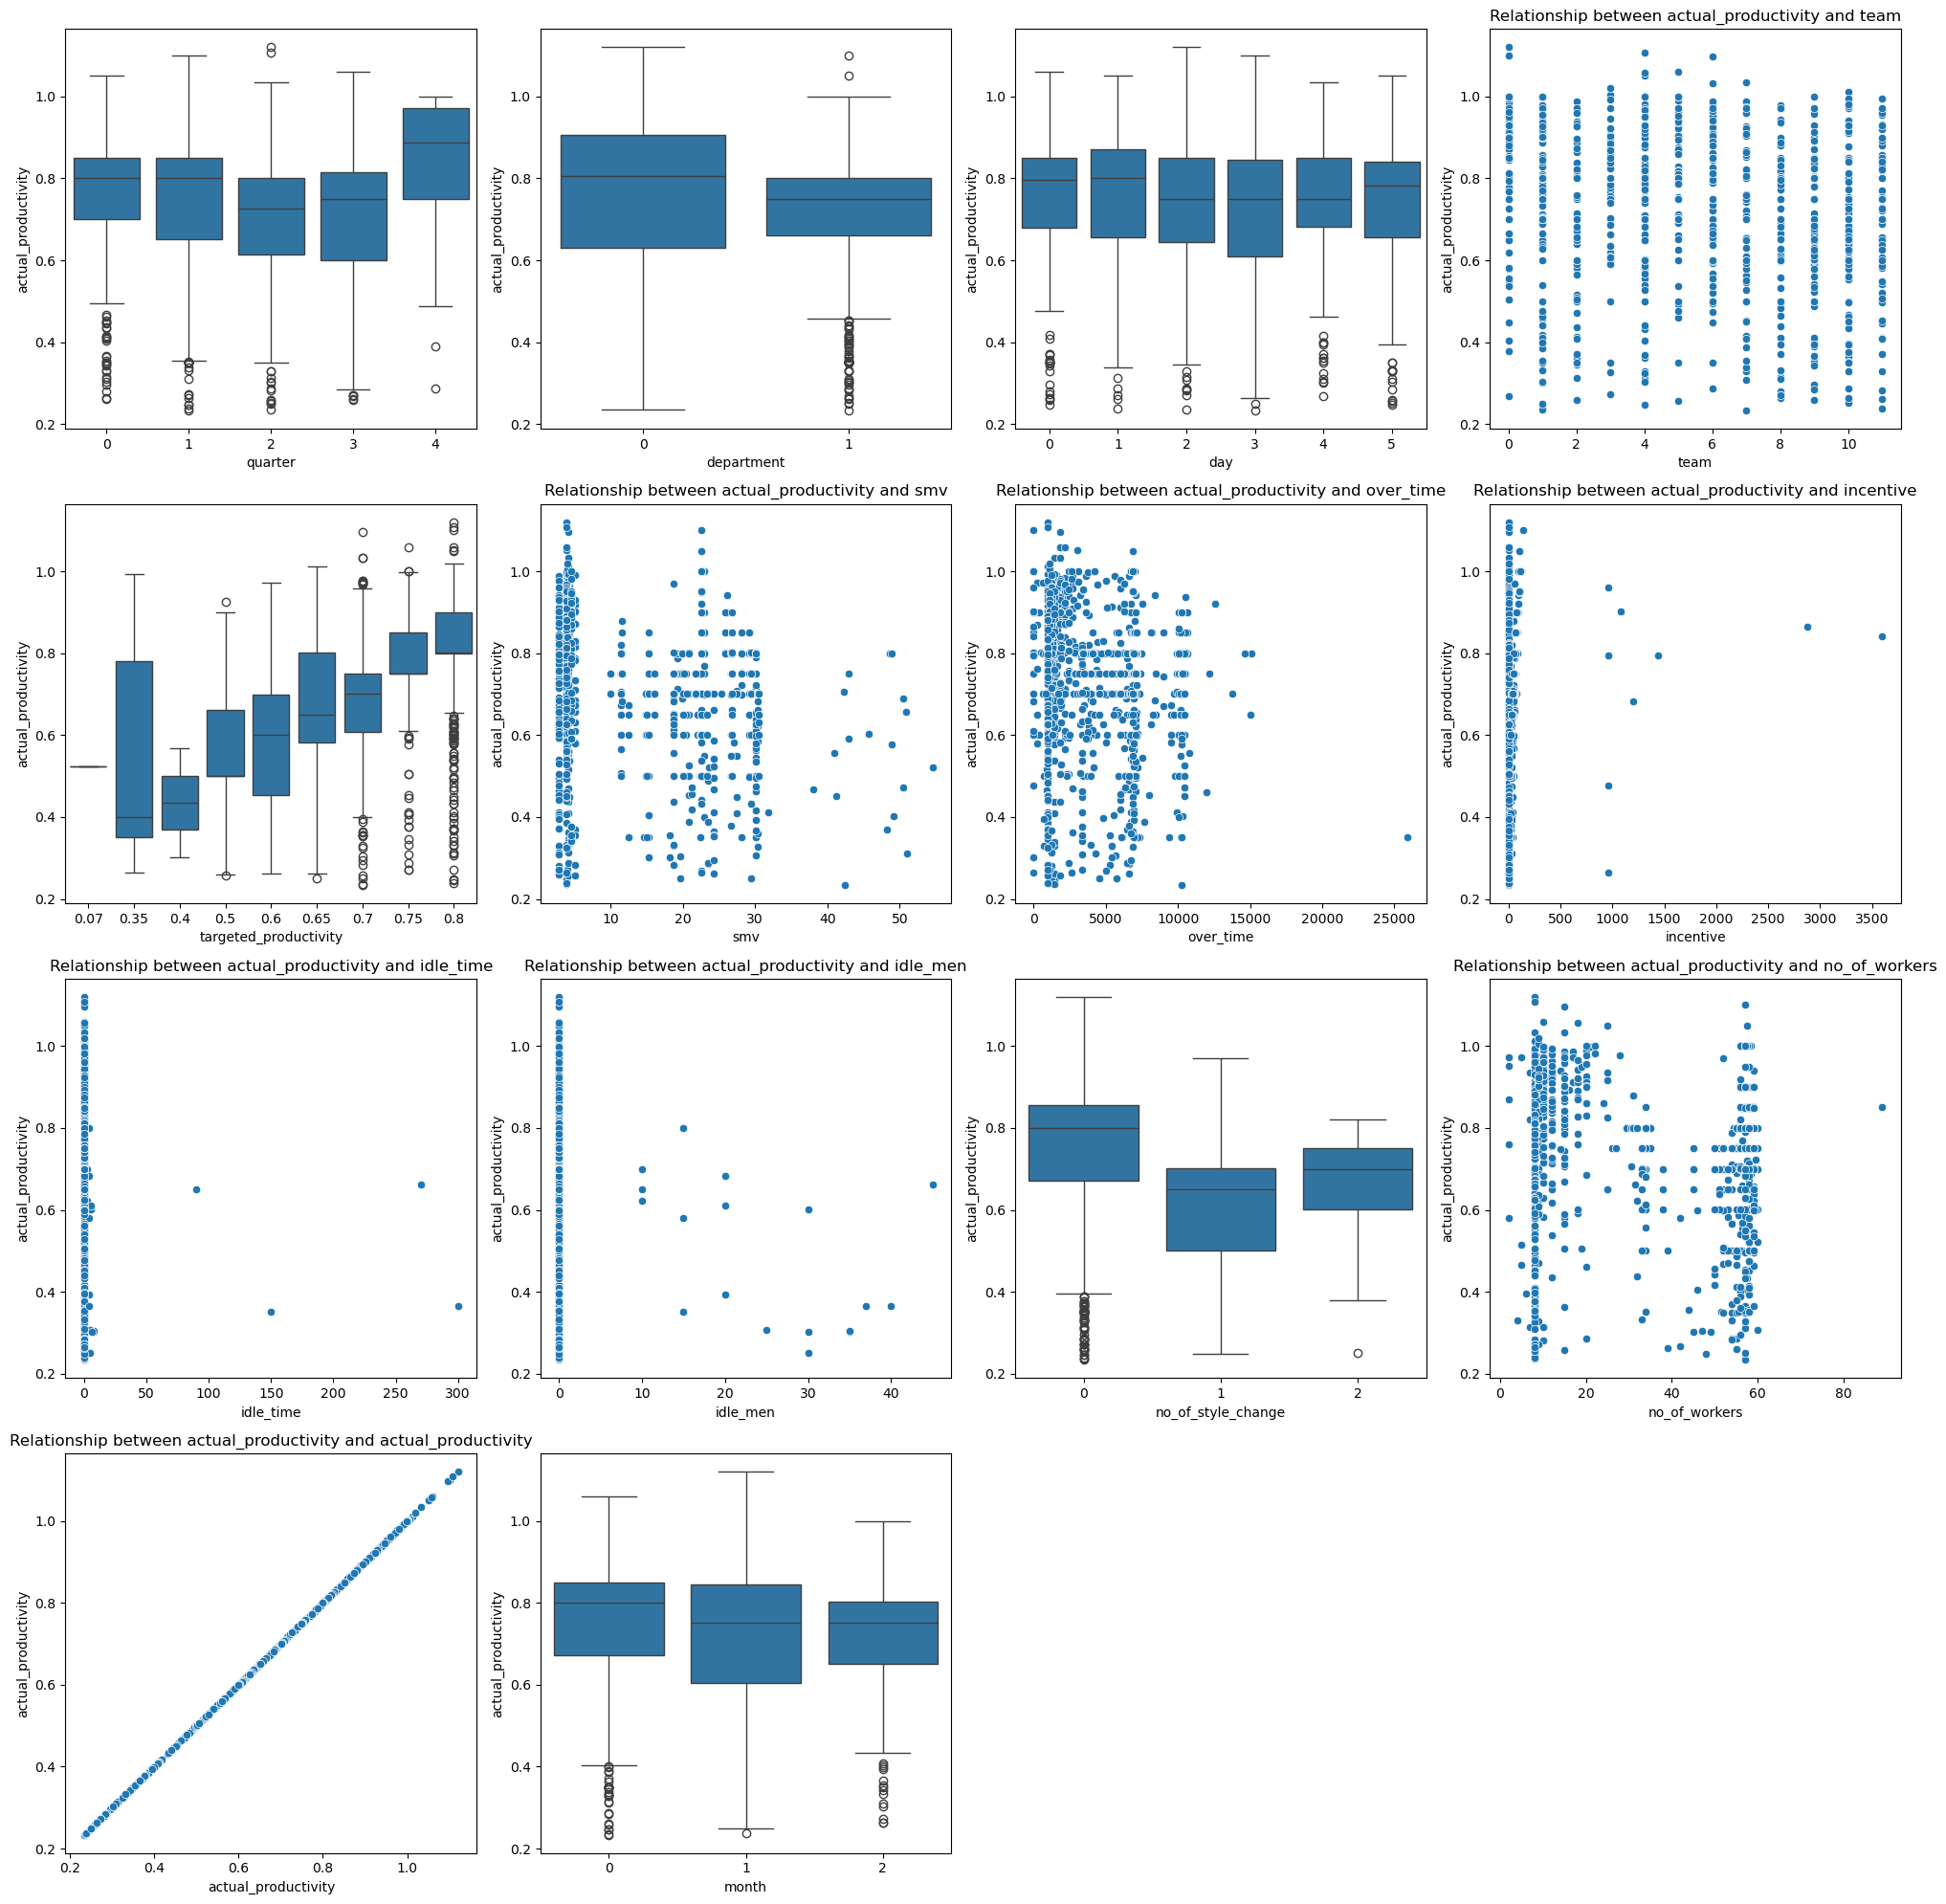

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = [ "quarter" ,	"department", "day","team",	"targeted_productivity",
           "smv",	"over_time","incentive",	"idle_time","idle_men", "no_of_style_change",
           "no_of_workers",	"actual_productivity",	"month"]
plt.figure(figsize =(20,20))
for i, columns in enumerate(columns,1):
    plt.subplot(4,4,i)
    if data_ev [columns].dtype == "object" or data_ev[columns].nunique()<10:
        sns.boxplot(x=data_ev[columns],y=data_ev["actual_productivity"])
    else:
        sns.scatterplot(x=data_ev[columns],y=data_ev["actual_productivity"])
        plt.title(f"Relationship between actual_productivity and {columns}")
        plt.xlabel(columns)
        plt.ylabel("actual_productivity")

plt.tight_layout()
plt.show()

In [36]:
data_ev.corr()['actual_productivity']

quarter                 -0.051970
department              -0.087624
day                     -0.015690
team                    -0.157049
targeted_productivity    0.421594
smv                     -0.122089
over_time               -0.054206
incentive                0.076538
idle_time               -0.080851
idle_men                -0.181734
no_of_style_change      -0.207366
no_of_workers           -0.057991
actual_productivity      1.000000
month                   -0.092914
Name: actual_productivity, dtype: float64

In [37]:
x=data_ev.drop(["actual_productivity"],axis=1)
y=data_ev['actual_productivity']

In [38]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test =  train_test_split(x,y,train_size=0.8,random_state=0)

### Model Building

#### Linear Regression Model

In [39]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()


In [40]:
model_lr.fit(x_train,y_train)

LinearRegression()

In [41]:
pred_test = model_lr.predict(x_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Evaluate the model
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:",(r2_score(y_test, pred_test)))

test_MSE: 0.02150720312147617
test_MAE: 0.10727112243966817
R2_Score: 0.27256608178022723


### Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
model_rf =  RandomForestRegressor(n_estimators=200,max_depth=5)

In [43]:
model_rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=200)

In [44]:
pred_test = model_rf.predict(x_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Evaluate the model
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:",(r2_score(y_test, pred_test)))

test_MSE: 0.016230878668317066
test_MAE: 0.0870210777459702
R2_Score: 0.45102617020184477


### Xgboost Model

In [45]:
model_xgb =  xgb.XGBRegressor(n_estimators=200,max_depth=5,learning_rate=0.1)
model_xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
pred3 = model_xgb.predict(x_test)
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:{}".format(r2_score(y_test, pred_test)))

test_MSE: 0.016230878668317066
test_MAE: 0.0870210777459702
R2_Score:0.45102617020184477


### Compare Model 

In [48]:
import pickle

pickle.dump(model_xgb,open("model.pkl","wb"))
pickle.dump(encoder,open("mcle.pkl","wb"))
            

#### Testing the Model

In [49]:
model_xgb = pickle.load(open('model.pkl','rb'))
mcle = pickle.load(open('mcle.pkl','rb'))
data = pd.read_csv('garments_worker_productivity.csv')
data.drop(['wip'],axis=1,inplace=True)
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data.drop(['date'],axis=1,inplace=True)
data.drop(['actual_productivity'],axis=1,inplace=True)
data['department']=data['department'].apply(lambda x:'finishing' if x.replace(" ","") == 'finishing' else 'sweing' )
data[0:1]


,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,month
0,Quarter1,sweing,Thursday,8,0.8,26.16,7080,98,0.0,0,0,59.0,1


In [50]:
example_data = { 'quarter':['Quarter1'.lower()],
                'department':['sweing'.lower()],
                'day':['Thursday'.lower()],
                'team':[1],
                'targeted_productivity':[0.80],
                'smv':[0.16],
                'over_time':[0],
                'incentive':[0],
                'idle_time':[0],
                'idle_men':[0],
                'no_of_style_change':[0],
                'no_of_workers':[0],
                'month':[3]
}
example_df = pd.DataFrame(example_data)
example_encoded= mcle.transform(example_df)
example_array = example_encoded.to_numpy()
predicted_productivity_example = model_xgb.predict(example_array)
print("Predicted Productivity for example  data :",predicted_productivity_example)
                        

Predicted Productivity for example  data : [0.7783586]


In [51]:
data['no_of_style_change'].value_counts()

no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64

In [52]:
# Version check for key libraries used in model training

import sklearn
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import scipy
import flask

print("Library Versions:")
print(f"scikit-learn: {sklearn.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scipy: {scipy.__version__}")
print(f"flask: {flask.__version__}")



Library Versions:
scikit-learn: 1.5.1
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.13.1
flask: 3.0.3


C:\Users\nilesh sahni\AppData\Local\Temp\ipykernel_8836\2224052358.py:18: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Flask 3.1. Use feature detection or 'importlib.metadata.version("flask")' instead.
  print(f"flask: {flask.__version__}")


In [55]:
import xgboost  as xgb
print(f"xgboost: {xgb.__version__}")

xgboost: 2.1.4
